## patch selection by image stats
### Faster, more Controllable and Reliable than masking

In [1]:
import os
import sys
import time

import pandas as pd
import numpy as np

import openslide
from PIL.ImageStat import Stat

def accept_image(image_input, min_variance=600):
    """ is the image varied enough to be viable -- True or False
    """
    V = Stat(image_input).var
    
    if np.array(V).max() < min_variance:
        return False
    else:
        return True

    
def get_image_stats(image_input):
    """ get the image stats as a dict for display
    """
    stats_dict = {}
    im_stat = Stat(image_input)
    stats_dict['extrema'] = im_stat.extrema
    stats_dict['count'] = im_stat.count
    stats_dict['sum'] = im_stat.sum
    stats_dict['sum2'] = im_stat.sum2
    stats_dict['mean'] = im_stat.mean
    stats_dict['median'] = im_stat.median
    stats_dict['rms'] = im_stat.rms
    stats_dict['var'] = im_stat.var
    stats_dict['stddev'] = im_stat.stddev
    
    return stats_dict


file_ext_list = ['.svs', '.tif', '.tiff']
def get_file_size_dict(data_dir, reverse_dict=False):
    """ get directory listing with file sizes (avoid experimental waiting)
    """
    file_size_dict = {}
    for f in os.listdir(data_dir):
        ff = os.path.join(data_dir, f)
        if os.path.isfile(ff): 
            _, f_ext = os.path.splitext(ff)
            if f_ext in file_ext_list:
                file_size_dict[ff] = os.path.getsize(ff)
                
    return file_size_dict

"""
                Define the image directory and display the files ordered by size
"""
data_dir = '../../DigiPath_MLTK_data/Aperio'

file_size_dict = get_file_size_dict(data_dir)
rev_file_size_dict = {v:k for k, v in file_size_dict.items()}

ordered_keys = sorted(list(file_size_dict.values()))
files_list = []
for k in ordered_keys:
    files_list.append(rev_file_size_dict[k])

print('\nordered by size:\n')
count = 0
for f in files_list:
    _, f_only = os.path.split(f)
    print('%3i %30s: %i'%(count, f_only, file_size_dict[f]))
    count += 1


ordered by size:

  0         CMU-1-Small-Region.svs: 1938955
  1               JP2K-33003-1.svs: 63847265
  2           CMU-1-JP2K-33005.svs: 132565343
  3                      CMU-1.svs: 177552579
  4                      CMU-3.svs: 253815723
  5               JP2K-33003-2.svs: 289250433
  6                      CMU-2.svs: 390750635


../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs 

obj.level_count 1
obj.dimensions (2220, 2967)
obj.level_dimensions ((2220, 2967),)
obj.level_downsamples (1.0,)


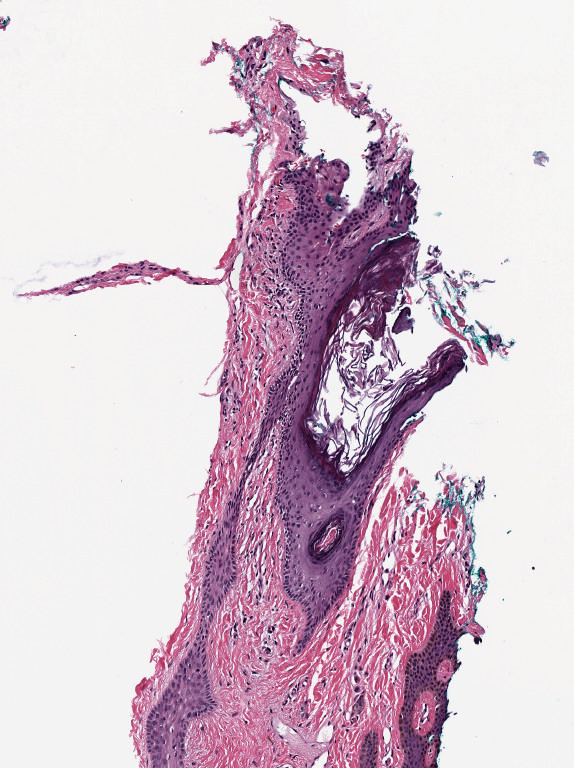

In [27]:
"""
            open a file, view the stats
"""
svs_file_name = files_list[0] 
print(svs_file_name,'\n')
output_dir = '../../DigiPath_MLTK_data/module_test'
if os.path.isdir(output_dir) == False:
    print(output_dir, '\n\tnot found')
patch_height = 224
patch_width = 224
patch_size = [patch_height, patch_width]

openslide_obj = openslide.OpenSlide(svs_file_name)

print('obj.level_count', openslide_obj.level_count)
print('obj.dimensions', openslide_obj.dimensions)
print('obj.level_dimensions', openslide_obj.level_dimensions)
print('obj.level_downsamples', openslide_obj.level_downsamples)
opns_thumnail_image = openslide_obj.associated_images['thumbnail']

openslide_obj.close()

display(opns_thumnail_image)

		accept image =  False
patch location (400, 400) with variance per channel
[1.0745671600749602, 2.470426197600912, 1.674949255154221, 0.0]


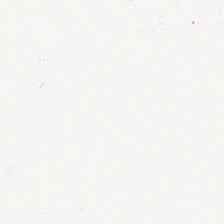

		accept image =  True
patch location (1300, 1200) with variance per channel
[5616.320064622129, 7850.168795735376, 4949.017309205126, 0.0]


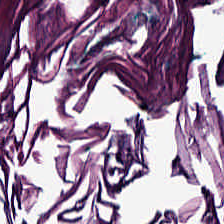

In [28]:
"""
                            get two patches - display with variance
"""
openslide_obj = openslide.OpenSlide(svs_file_name)

read_location_0 = (400,400)
test_sect_0 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_0)

read_location_1 = (1300,1200)
test_sect_1 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_1)

openslide_obj.close()

print('\t\taccept image = ', accept_image(test_sect_0))
print('patch location',read_location_0, 'with variance per channel')
print(Stat(test_sect_0).var)
display(test_sect_0)

print('\t\taccept image = ', accept_image(test_sect_1))
print('patch location',read_location_1, 'with variance per channel')
print(Stat(test_sect_1).var)
display(test_sect_1)

In [16]:
"""
                    Display the image stats that are available
"""
ts_0_dict = get_image_stats(test_sect_0)
print('\t\t\tpatch location',read_location_0, 'stats dictionary:\n')
for k, v in ts_0_dict.items():
    print(k, v)
    
print('\n\n')

ts_1_dict = get_image_stats(test_sect_1)
print('\t\t\tpatch location',read_location_1, 'stats dictionary:\n')
for k, v in ts_1_dict.items():
    print(k, v)

			patch location (400, 400) stats dictionary:

extrema [(188, 255), (177, 255), (190, 255), (255, 255)]
count [50176, 50176, 50176, 50176]
sum [12332436.0, 12226201.0, 12220504.0, 12794880.0]
sum2 [3031163964.0, 2979237295.0, 2976421694.0, 3262694400.0]
mean [245.7835618622449, 243.6663145727041, 243.55277423469389, 255.0]
median [246, 243, 243, 255]
rms [245.785747855428, 243.67138380130234, 243.55621278602382, 255.0]
var [1.0745671600749602, 2.470426197600912, 1.674949255154221, 0.0]
stddev [1.0366133127039032, 1.5717589502213474, 1.2941983059617337, 0.0]



			patch location (1300, 1200) stats dictionary:

extrema [(0, 255), (0, 255), (0, 255), (255, 255)]
count [50176, 50176, 50176, 50176]
sum [8039137.0, 6775614.0, 8089145.0, 12794880.0]
sum2 [1569825117.0, 1308848318.0, 1552416815.0, 3262694400.0]
mean [160.21876992984693, 135.0369499362245, 161.21542171556123, 255.0]
median [163, 122, 161, 255]
rms [176.8795474396499, 161.50896768852738, 175.8960758747374, 255.0]
var [5616.3200

min_variance on at least one channel =  700


	Var [596.741395898686, 687.0052768575426, 438.2519665916298, 0.0]
	accept image =  False
	patch location (0, 0)


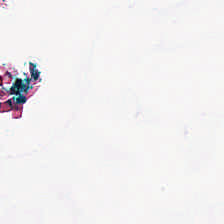



	Var [806.0677424585351, 1612.0241778845214, 913.5754807328007, 0.0]
	accept image =  True
	patch location (700, 0)


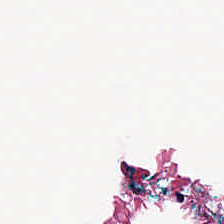



	Var [340.91807007541576, 939.3975585431468, 471.2484707588102, 0.0]
	accept image =  True
	patch location (0, 1100)


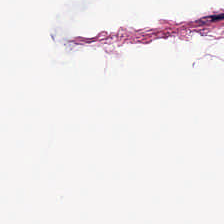



	Var [524.726262973574, 516.1266357150993, 279.32579714136807, 0.0]
	accept image =  False
	patch location (1900, 500)


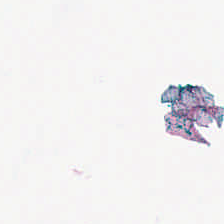



	Var [51.598077998468085, 51.725283141333456, 26.982133803794124, 0.0]
	accept image =  False
	patch location (1900, 800)


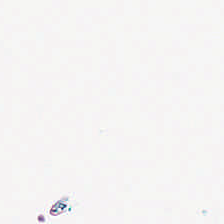

In [32]:
"""
                            get two patches
"""
openslide_obj = openslide.OpenSlide(svs_file_name)

read_location_0 = (0,0)
test_sect_0 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_0)

read_location_1 = (700,0)
test_sect_1 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_1)

read_location_2 = (0,1100)
test_sect_2 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_2)

read_location_3 = (1900,500)
test_sect_3 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_3)

read_location_4 = (1900,800)
test_sect_4 = openslide_obj.read_region(level=0, size=patch_size, location=read_location_4)

openslide_obj.close()

min_variance = 700
print('min_variance on at least one channel = ', min_variance)

print('\n\n\tVar',Stat(test_sect_0).var)
print('\taccept image = ', accept_image(test_sect_0, min_variance))
print('\tpatch location',read_location_0)
display(test_sect_0)

print('\n\n\tVar',Stat(test_sect_1).var)
print('\taccept image = ', accept_image(test_sect_1, min_variance))
print('\tpatch location',read_location_1)
display(test_sect_1)

print('\n\n\tVar',Stat(test_sect_2).var)
print('\taccept image = ', accept_image(test_sect_2, min_variance))
print('\tpatch location',read_location_2)
display(test_sect_2)

print('\n\n\tVar',Stat(test_sect_3).var)
print('\taccept image = ', accept_image(test_sect_3, min_variance))
print('\tpatch location',read_location_3)
display(test_sect_3)

print('\n\n\tVar',Stat(test_sect_4).var)
print('\taccept image = ', accept_image(test_sect_4, min_variance))
print('\tpatch location',read_location_4)
display(test_sect_4)